In [102]:
#libraries for classfication
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression #Regression
from sklearn.linear_model import LinearRegression #Regression
from sklearn.metrics import mean_squared_error, r2_score #Regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,PrecisionRecallDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier
#for precision recall curve
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import label_binarize
from collections import Counter

PREVISUALIZACION DE LOS DATOS

In [103]:
def show_correlation_matrix(df):
    corr = df.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, fmt=".2f", square=True, cbar=True)
    plt.show()

In [104]:
#DATASET LOADING
#ESTE ES EL DATASET SIN MODIFICAR
df = pd.read_csv("B.HEALTH_classification.csv")

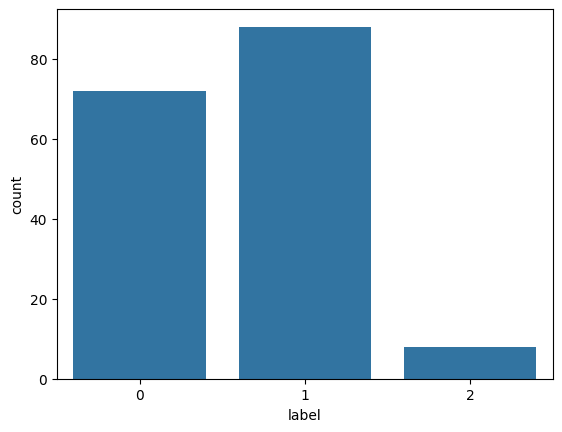

label
1    88
0    72
2     8
Name: count, dtype: int64


In [105]:
#GRAFICA DEL DATASET
#GRAFICAMOS CANTIDAD DE DATOS POR CLASE
#0 es buena calidad 2 es mala calidad
sns.countplot(x='label', data=df)
plt.show()
print(df["label"].value_counts())

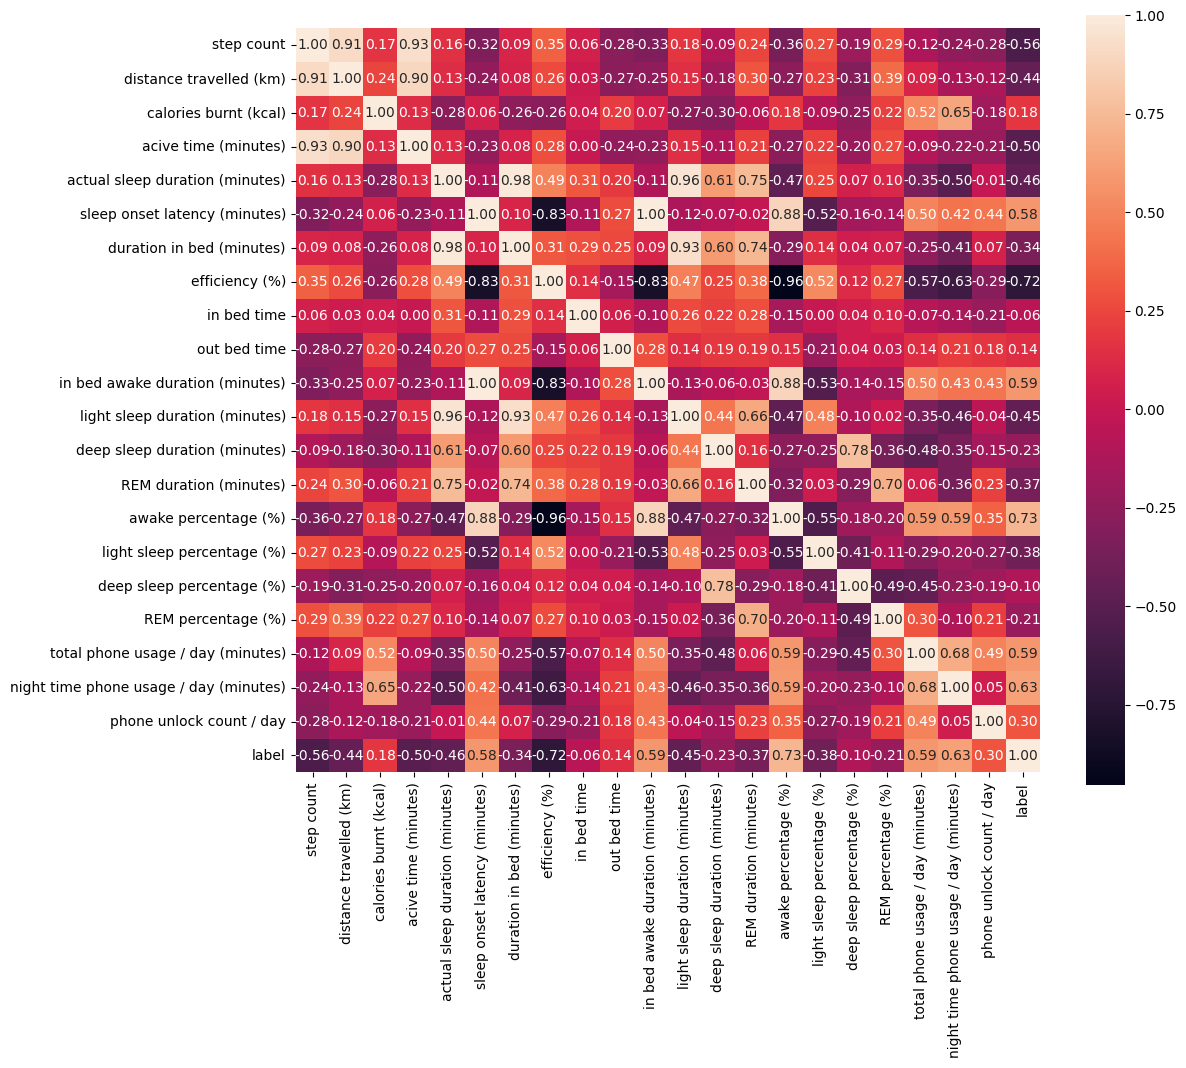

In [106]:
#MOSTRAR MATRIZ DE CORRELACION
base_df = df.drop(columns=["subject","day"])
columns = [] #si queremos ver la matriz de correlacion sin alguna columna agregarlo aqui
show_correlation_matrix(base_df.drop(columns=columns))

 PREPARACION DE LOS DATOS PARA EL ENTRENAMIENTO Y VISUALIZACION DE CARACTERISTICAS

In [107]:
def normalize_data(X, how="minmax"):
    if how == "minmax":
        scaler = MinMaxScaler()
    elif how == "standard":
        scaler = StandardScaler()
    return scaler.fit_transform(X)

In [108]:
def apply_tsne(X, n_components=2, pca=False):
    if pca:
        reduccion = TSNE(n_components, init='pca')
    else:
        reduccion = TSNE(n_components)
    x_new = reduccion.fit_transform(X)
    return x_new

In [109]:
def plot_data_TSNE(x,y): #plot with TSNE and PCA to reduce dimensions
    fig, ax = plt.subplots(1, 1, figsize=(12, 5))
    
    x_new = apply_tsne(x, n_components=2, pca=True)
    tmp_df = pd.DataFrame(np.column_stack([x_new, y]))
    tmp_df.columns = ["x1", "x2", "Y"]
    
    sns.scatterplot(x="x1", y="x2", hue="Y", data=tmp_df, ax=ax)
    

In [110]:
#separate test and train data
def split_data(X, y, test_size=0.3):
    return train_test_split(X, y, test_size=test_size, random_state=42)

In [111]:
#REMOVEMOS COLUMNAS QUE NO QUEREMOS Y APLICAMOS SMOTE DE SER NECESARIO
remove_columns = ["subject","day", "label"] #remover columnas que no queremos para las variables
use_smote = False

X, Y = df.drop(columns=remove_columns), df["label"]

if use_smote:
    smote = SMOTE(sampling_strategy='minority')
    X, Y = smote.fit_resample(df.drop(columns=remove_columns), df["label"])
#separamos en X variables y Y labels



In [112]:
#NORMALIZAMOS LOS DATOS
X = normalize_data(X, how="minmax")

In [113]:
#SEPARAMOS LOS DATOS DE ENTRENAMIENTO Y PRUEBA
X_train, X_test, y_train, y_test = split_data(X, Y)


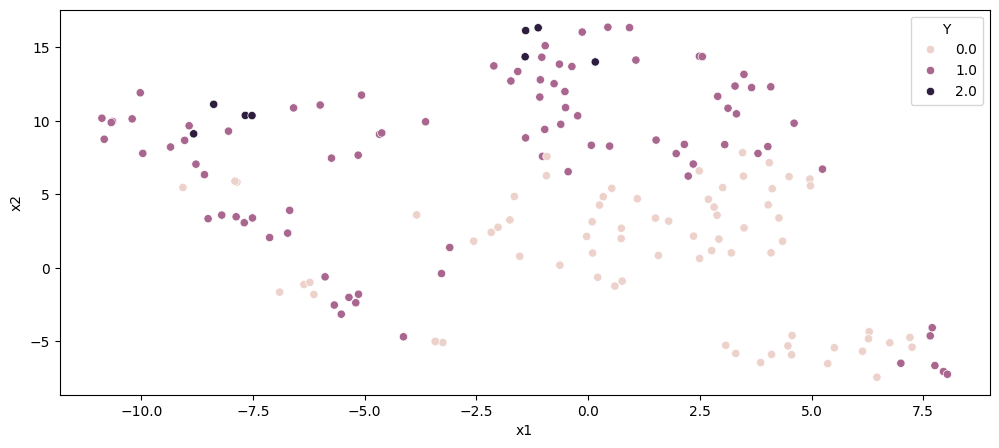

In [114]:
#PLOTTING DATA
plot_data_TSNE(X, Y)

ENTRENAMIENTO Y TUNNING DE MODELOS PARA CLASIFICACION

In [115]:
def select_model(model_name="DecisionTree"): 
    if model_name == "DecisionTree":
        return DecisionTreeClassifier()
    elif model_name == "SVM":
        return SVC()
    elif model_name == "RandomForest":
        return RandomForestClassifier()
    elif model_name == "XGBoost":
        return XGBClassifier()
    elif model_name == "MLP":
        return MLPClassifier()
    else:
        print("Invalid model name")
        return None

In [116]:
#comparing each model accuracy
def compare_models_accuracy(X_train, y_train, X_test, y_test):
    models = ["DecisionTree", "SVM", "RandomForest"]
    accuracies = []
    for model_name in models:
        model = select_model(model_name)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
    return list(zip(models, accuracies))
        

In [117]:
def compare_models_accuracy(X_train, y_train, X_test, y_test):
    models = ["DecisionTree", "SVM", "RandomForest", "XGBoost"]
    accuracies = []
    for model_name in models:
        model = select_model(model_name)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
    return list(zip(models, accuracies))

In [118]:
#plotting comparison of models with no hyperparameter tuning
comparison_list = compare_models_accuracy(X_train, y_train, X_test, y_test)
print(comparison_list)


[('DecisionTree', 0.8431372549019608), ('SVM', 0.8823529411764706), ('RandomForest', 0.8431372549019608), ('XGBoost', 0.8627450980392157)]


In [119]:
def parameter_tunning(model,parameters, method="grid"):
    if method == "grid":
        clf = GridSearchCV(model, param_grid=parameters, scoring="accuracy", cv=5, n_jobs=-1)  
    # clf_svc = RandomizedSearchCV(clf_svc, param_distributions=parameters, scoring="accuracy", cv=5, n_jobs=-1, n_iter=15)
    else:
        clf = RandomizedSearchCV(model, param_distributions=parameters, scoring="accuracy", cv=5, n_jobs=-1, n_iter=15)
    
    clf.fit(X_train, y_train)
    
    print("-----------------")
    print("Model", model.__class__.__name__)
    print("Best score : ", clf.best_score_)
    print("Best Parameters : ", clf.best_params_)
    print("-----------------")

In [120]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    confusion = confusion_matrix(y_test, y_pred)
    print("Model", model.__class__.__name__)
    print("Accuracy: ", accuracy)
    print("F1 Score: ", f1)
    print("Confusion Matrix: ")
    print(confusion)
    return accuracy, f1, confusion

In [121]:
# parameters = {
#    "n_estimators":[i for i in range(1,200)],                   
#    "learning_rate":[0.1*i for i in range(1,10)],
#    "max_depth":[i for i in range(1,20)],                                            
# }
# useGridSearch = False
# parameter_tunning(select_model("XGBoost"), parameters, useGridSearch)

In [122]:
#DecisionTree parameters
# parameters = {
#     "criterion": ["gini", "entropy","log_loss"],
#     "max_depth": [i if i!=0 else None for i in range(1, 10)],
#     "max_features": ["auto", "sqrt", "log2"]
# }
# model = DecisionTreeClassifier()
# parameter_tunning(model, parameters)

In [123]:
# decision_tree = DecisionTreeClassifier(criterion="entropy", max_depth=9, max_features="sqrt")
# decision_tree.fit(X_train, y_train)
# y_pred = decision_tree.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy DecisionTree: ", accuracy)

In [124]:
svm = SVC()
parameters = {
    "C": [0.1, 1, 10, 100],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "degree": [2, 3, 4, 5],
    "gamma": [0.01*i for i in range(1, 100)]
}
parameter_tunning(svm, parameters)

-----------------
Model SVC
Best score :  0.9155797101449276
Best Parameters :  {'C': 100, 'degree': 2, 'gamma': 0.04, 'kernel': 'sigmoid'}
-----------------


In [125]:
svm = SVC(C=10, degree=2, gamma=0.44, kernel="rbf")
clf = svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy SVM: ", accuracy)

Accuracy SVM:  0.9215686274509803


In [126]:

def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in"""
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

In [127]:
def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier."""
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

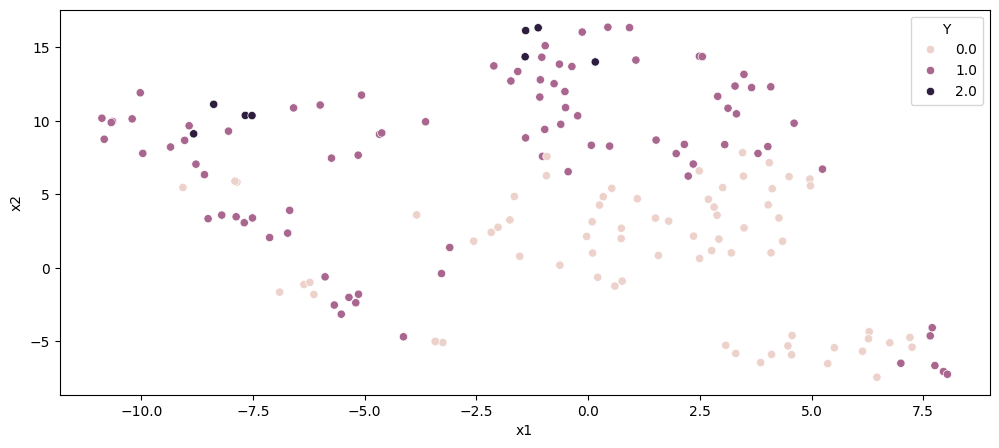

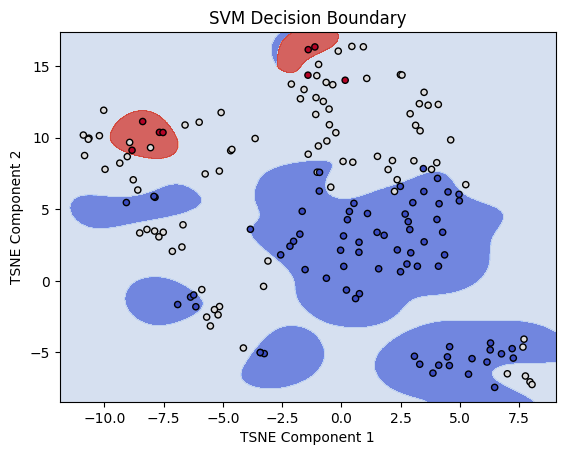

In [128]:
#APPLYTING TSNE TO VISUALIZE DATA WITH SVC
plot_data_TSNE(X, Y)
plt.show()
X_tsne = apply_tsne(X, n_components=2, pca=True)
X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne = split_data(X_tsne, Y)
clf = svm.fit(X_train_tsne, y_train_tsne)

 # Create a meshgrid for plotting
X0, X1 = X_tsne[:, 0], X_tsne[:, 1]
xx, yy = make_meshgrid(X0, X1)

# Plot the decision boundaries
fig, ax = plt.subplots()
plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=Y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_xlabel('TSNE Component 1')
ax.set_ylabel('TSNE Component 2')
ax.set_title('SVM Decision Boundary')
plt.show()



In [129]:
# random_f= RandomForestClassifier()
# parameters = {
#     "n_estimators": [50, 100, 200, 300],
#     "criterion": ["gini", "entropy","log_loss"],
#     "max_depth": [i if i!=0 else None for i in range(1, 10)],
#     "max_features": ["auto", "sqrt", "log2"]
# }
# parameter_tunning(random_f, parameters)

In [130]:
# random_f= RandomForestClassifier(criterion="entropy", max_depth=5, max_features="log2", n_estimators=50)
# random_f.fit(X_train, y_train)
# y_pred = random_f.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy RandomForest: ", accuracy)

In [131]:
# xgboost = XGBClassifier()
# parameters = {
#    "n_estimators":[i for i in range(1,200)],                   
#    "learning_rate":[0.1*i for i in range(1,10)],
#    "max_depth":[i for i in range(1,20)],
#    "max_features":[i for i in range(1,20)]                                               
# }
# parameter_tunning(xgboost, parameters, method="random")

In [132]:
# mlp_model = MLPClassifier()
# parameters = {
#     "hidden_layer_sizes": [(100,), (200,), (300,)],
#     "activation": ["identity", "logistic", "tanh", "relu"],
#     "solver": ["lbfgs", "sgd", "adam"],
#     "alpha": [0.0001, 0.001, 0.01, 0.1],
#     "learning_rate": ["constant", "invscaling", "adaptive"]
# }
# parameter_tunning(mlp_model, parameters)

In [133]:
# mlp_model = MLPClassifier(activation="relu", alpha=0.1, hidden_layer_sizes=(100,), learning_rate="invscaling", solver="adam")
# mlp_model.fit(X_train, y_train)
# y_pred = mlp_model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy MLP: ", accuracy)

In [134]:
def decimal_to_time(decimal_time): ##calculo para pasar tiempo decimal a horas minutos y segundos
    """
    Convert a decimal time representation to HH:MM:SS format.
    
    Parameters:
    decimal_time (float): The decimal representation of time.
    
    Returns:
    str: The time in HH:MM:SS format.
    """
    total_seconds = int(decimal_time * 24 * 3600)
    hours = total_seconds // 3600
    minutes = (total_seconds % 3600) // 60
    seconds = total_seconds % 60
    return f"{hours:02}:{minutes:02}:{seconds:02}"


print(decimal_to_time(0.457638889)) 
print(decimal_to_time(0.707638889)) 

10:59:00
16:59:00


ANALISIS Y COMPARACION DE MODELOS


In [135]:
def graph_precision_recall_curve(y_test, y_score, n_classes=3):
    precision = dict()
    recall = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                            y_score[:, i])
        plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
        
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="best")
    plt.title("precision vs. recall curve")
    plt.show()

In [136]:
#classifiers with best hyperparameters
decision_tree = DecisionTreeClassifier(criterion="entropy", max_depth=5, max_features="log2")
xgbModel = XGBClassifier(learning_rate=0.2, max_depth=19, n_estimators=154)
svm = SVC(C=100, degree=2, gamma=0.04, kernel="sigmoid",probability=True)
random_f= RandomForestClassifier(criterion="entropy", max_depth=6, max_features="sqrt", n_estimators=50)
mlp_model = MLPClassifier(activation="relu", alpha=0.01, hidden_layer_sizes=(200,), learning_rate="invscaling", solver="adam")
train_and_evaluate_model(decision_tree, X_train, y_train, X_test, y_test)
train_and_evaluate_model(svm, X_train, y_train, X_test, y_test)
train_and_evaluate_model(random_f, X_train, y_train, X_test, y_test)
train_and_evaluate_model(xgbModel, X_train, y_train, X_test, y_test)
train_and_evaluate_model(mlp_model, X_train, y_train, X_test, y_test)

Model DecisionTreeClassifier
Accuracy:  0.803921568627451
F1 Score:  0.8048293391430645
Confusion Matrix: 
[[19  3]
 [ 7 22]]
Model SVC
Accuracy:  0.9215686274509803
F1 Score:  0.9215686274509803
Confusion Matrix: 
[[20  2]
 [ 2 27]]
Model RandomForestClassifier
Accuracy:  0.8627450980392157
F1 Score:  0.8623122879423744
Confusion Matrix: 
[[18  4]
 [ 3 26]]
Model XGBClassifier
Accuracy:  0.8823529411764706
F1 Score:  0.8823529411764706
Confusion Matrix: 
[[19  3]
 [ 3 26]]
Model MLPClassifier
Accuracy:  0.9019607843137255
F1 Score:  0.9021901158124068
Confusion Matrix: 
[[20  2]
 [ 3 26]]


c:\Users\oscar\Desktop\FinalMachineLearning\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


(0.9019607843137255,
 np.float64(0.9021901158124068),
 array([[20,  2],
        [ 3, 26]]))

c:\Users\oscar\Desktop\FinalMachineLearning\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


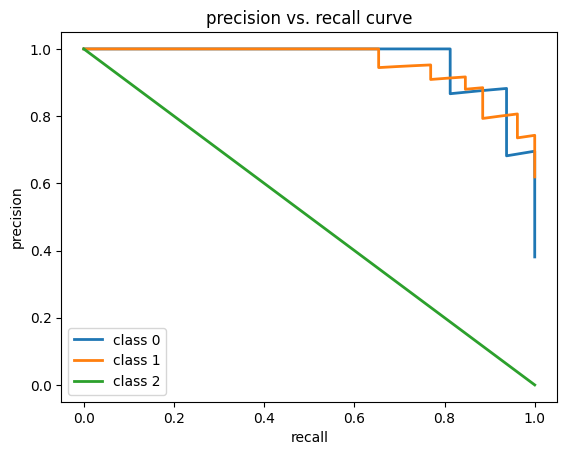

In [137]:
y = df["label"]
n_classes = len(set(y))
Y = label_binarize(y, classes=[0, 1, 2])
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    Y,
                                                    random_state = 42)
clf = OneVsRestClassifier(svm)
clf.fit(X_train, y_train)
y_score = clf.predict_proba(X_test)
graph_precision_recall_curve(y_test, y_score, n_classes)



REGRESION

In [138]:
new_df_regression = df.drop(['subject','label'],axis=1)
new_X = new_df_regression.drop('calories burnt (kcal)',axis=1)
new_Y = new_df_regression['calories burnt (kcal)']

#Filas con valores nulos
new_X = new_X.dropna()
new_Y = new_Y[new_X.index]

#Separar en datos de entrenamiento y prueba
new_X_train, new_X_test, new_Y_train, new_Y_test = split_data(new_X, new_Y)

#Normalizamos los datos
new_X = normalize_data(new_X, how="minmax")

#Entrenar el modelo
model_regression = LinearRegression()
model_regression.fit(X_train, y_train)

#Predecir
new_Y_pred = model_regression.predict(new_X_test)
mse = mean_squared_error(new_Y_test, new_Y_pred)
print("Mean Squared Error: ", mse)
#AUxilio

c:\Users\oscar\Desktop\FinalMachineLearning\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


ValueError: y_true and y_pred have different number of output (1!=3)